In [1]:
%load_ext autoreload
%autoreload 1
%aimport pycabnn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycabnn as cbn

from scipy.spatial import KDTree
from scipy.spatial.distance import pdist

from tqdm.autonotebook import tqdm, trange

In [3]:
from pycabnn.util import HocParameterParser

h = HocParameterParser()
config_hoc = str("../test_data/params/Parameters.hoc")
h.load_file(config_hoc)


In [4]:
mlipop = cbn.create_population("MLI", h)
mlipop.load_somata("../../big_test_data/MLIcoordinates.dat")
mlipop.add_dendrites()

Successfully read ../../big_test_data/MLIcoordinates.dat.


In [5]:
mlipop.som.shape

(19724, 3)

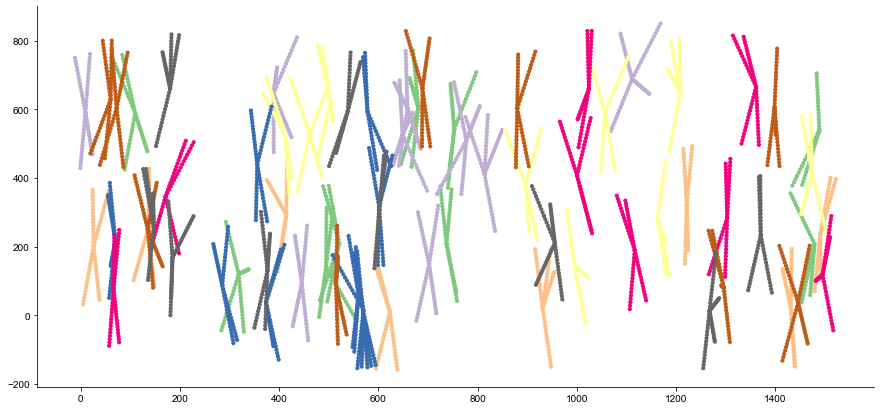

In [6]:
ncell = 70
nidx = ncell*90*4

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(
    mlipop.dends.coo[:nidx:5,0],
    mlipop.dends.coo[:nidx:5,1], 
    10, 
    mlipop.dends.idx[:nidx:5], 
    cmap='Accent'
)

In [7]:
z = np.reshape(mlipop.dends.coo, (-1, 4, 90, 3))

In [8]:
z.shape

(19724, 4, 90, 3)

In [14]:

# fext = 1.25
# cdist_gap = 2
fext = 0.5
# cdist_gap = 1.5
# fext = 1
cdist_gap = 6

dend_coo_rescaled = np.zeros(mlipop.dends.coo.shape)
dend_coo_rescaled[:,0] = fext*mlipop.dends.coo[:,0]
dend_coo_rescaled[:,1:] = mlipop.dends.coo[:,1:]

tree = KDTree(dend_coo_rescaled)
for _ in trange(1):
    d = tree.query_pairs(cdist_gap)

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
src_idx = np.zeros(len(d), dtype='int')
tgt_idx = np.zeros(len(d), dtype='int')

for i, pp in tqdm(enumerate(d)):
    src_idx[i], tgt_idx[i] = pp
    # gap_cons.append({'src_idx': src, 'tgt_idx': tgt})
gap_cons = pd.DataFrame({'src_idx': src_idx, 'tgt_idx': tgt_idx})
del(d, tree)
gap_cons

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [10]:
gap_cons['src_cell'] = mlipop.dends.idx[gap_cons.src_idx]
gap_cons['tgt_cell'] = mlipop.dends.idx[gap_cons.tgt_idx]
gap_cons = gap_cons[gap_cons.src_cell!=gap_cons.tgt_cell]
gap_cons

,src_idx,tgt_idx,src_cell,tgt_cell
1,3262472,3402929,9062,9452
2,3122910,5485012,8674,15236
3,2642979,3127245,7341,8686
4,4282770,5305458,11896,14737
6,1595218,5004367,4431,13901
...,...,...,...,...
118251321,1825144,5952919,5069,16535
118251322,1764214,3325304,4900,9236
118251323,644357,2982592,1789,8284
118251324,212869,1715649,591,4765


In [11]:
z1c = mlipop.som[gap_cons.src_cell]
z2c = mlipop.som[gap_cons.tgt_cell]

z1 = np.zeros((z1c.shape[0], 2))
z2 = np.zeros((z2c.shape[0], 2))

z1 = z1c[:,1:]
z2 = z2c[:,1:]

gap_cons['dist_yz'] = np.linalg.norm(z1 - z2, axis=-1)

z1 = np.zeros((z1c.shape[0], 1))
z2 = np.zeros((z2c.shape[0], 1))

z1 = z1c[:,0]
z2 = z2c[:,0]

gap_cons['dist_x'] = np.abs(z1 - z2)
gap_cons

/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_27986/2544255798.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_cons['dist_yz'] = np.linalg.norm(z1 - z2, axis=-1)
/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_27986/2544255798.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_cons['dist_x'] = np.abs(z1 - z2)


,src_idx,tgt_idx,src_cell,tgt_cell,dist_yz,dist_x
1,3262472,3402929,9062,9452,122.897921,4.676639
2,3122910,5485012,8674,15236,104.556688,16.927086
3,2642979,3127245,7341,8686,96.041031,9.740587
4,4282770,5305458,11896,14737,124.312469,22.673616
6,1595218,5004367,4431,13901,99.242715,14.242800
...,...,...,...,...,...,...
118251321,1825144,5952919,5069,16535,28.344252,0.875002
118251322,1764214,3325304,4900,9236,94.538866,6.662358
118251323,644357,2982592,1789,8284,115.708073,0.025453
118251324,212869,1715649,591,4765,145.190995,30.997356


In [12]:
f1 = lambda xc: 1# /(1+np.exp((xc-115)/10))*1/(1+np.exp((-xc+15)/10))
f2 = lambda xc: 1# /(1+np.exp((xc-25)/5))
gap_cons['p_retain'] = f1(gap_cons.dist_yz)*f2(gap_cons.dist_x)

r = np.random.rand(gap_cons.shape[0])
z = (gap_cons.p_retain>=r)
gap_cons_final = gap_cons[z]

idx = gap_cons_final.loc[:,['src_cell', 'tgt_cell']].drop_duplicates().index
print(gap_cons_final.shape[0])
gap_cons_final = gap_cons_final.loc[idx,:]
print(gap_cons_final.shape[0])
gap_cons_final

/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_27986/1496454906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_cons['p_retain'] = f1(gap_cons.dist_yz)*f2(gap_cons.dist_x)


99242697
2027752


,src_idx,tgt_idx,src_cell,tgt_cell,dist_yz,dist_x,p_retain
1,3262472,3402929,9062,9452,122.897921,4.676639,1
2,3122910,5485012,8674,15236,104.556688,16.927086,1
3,2642979,3127245,7341,8686,96.041031,9.740587,1
4,4282770,5305458,11896,14737,124.312469,22.673616,1
6,1595218,5004367,4431,13901,99.242715,14.242800,1
...,...,...,...,...,...,...,...
118239141,639680,5293678,1776,14704,167.102869,8.424783,1
118240879,606680,2228333,1685,6189,182.840900,23.670268,1
118241919,1357405,5362350,3770,14895,162.965371,5.720465,1
118245539,4006155,4038929,11128,11219,159.734959,16.265102,1


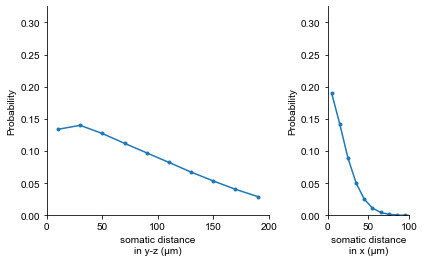

In [13]:
df_plot_yz = pd.DataFrame()
df_plot_x = pd.DataFrame()

nc, x = np.histogram(gap_cons_final.dist_yz, np.arange(0, 220, 20))
dA = (x[1:]**2-x[:-1]**2)*np.pi

n = nc/(1e-4*1e2*dA)/mlipop.som.shape[0]
# n0, x0 = np.histogram(dist0, np.arange(201))
xc = (x[:-1]+x[1:])/2

df_plot_yz['d'] = xc
df_plot_yz['nc_gap'] = nc
df_plot_yz['n_gap'] = n


fig = plt.figure(figsize=(4*1.5,2.5*1.5))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0:2])

ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-115)/5))*1/(1+np.exp((-xc+4)/10)), '.-', label='corrected')

# ax.plot(xc, n*np.exp(-xc/48), '.-', label='corrected')
# ax.plot(x0[:-1], n0)
ax.set(
    xlim=[0, 200], ylim=[0, 0.65/2],
    xlabel='somatic distance\nin y-z (μm)',
    ylabel='Probability'
)
# ax.legend()

nc, x = np.histogram(gap_cons_final.dist_x, np.arange(0, 111, 10))
n = nc/(2e2*mlipop.som.shape[0])
xc = (x[:-1]+x[1:])/2

df_plot_x['d'] = xc
df_plot_x['nc_gap'] = nc
df_plot_x['n_gap'] = n

ax = fig.add_subplot(gs[0, 2])
ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-25)/5)), '.-', label='corrected')
ax.set(
    xlim=[0, 100], ylim=[0,0.65/2],
    xlabel='somatic distance\nin x (μm)',
    ylabel='Probability'
)
# ax.legend()

plt.tight_layout()
# plt.savefig('ngap_vs_dist.png', dpi=60)

In [77]:
# nc, x = np.histogram(gap_cons.dist_yz, np.arange(0, 220, 20))
# dA = (x[1:]**2-x[:-1]**2)*np.pi

# n = nc/(1e-4*1e2*dA)/mlipop.som.shape[0]
# # n0, x0 = np.histogram(dist0, np.arange(201))

# fig = plt.figure(figsize=(4*1.5,2.5*1.5))
# gs = fig.add_gridspec(1, 3)
# ax = fig.add_subplot(gs[0, 0:2])

# xc = (x[:-1]+x[1:])/2
# ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-115)/5))*1/(1+np.exp((-xc+4)/10)), '.-', label='corrected')

# # ax.plot(xc, n*np.exp(-xc/48), '.-', label='corrected')
# # ax.plot(x0[:-1], n0)
# ax.set(
#     xlim=[0, 200], ylim=[0, 0.65],
#     xlabel='somatic distance\nin y-z (μm)',
#     ylabel='Probability'
# )
# # ax.legend()

# nc, x = np.histogram(gap_cons.dist_x, np.arange(0, 111, 10))
# n = nc/(2e2*mlipop.som.shape[0])

# ax = fig.add_subplot(gs[0, 2])
# xc = (x[:-1]+x[1:])/2
# ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-25)/5)), '.-', label='corrected')
# ax.set(
#     xlim=[0, 100], ylim=[0,0.65],
#     xlabel='somatic distance\nin x (μm)',
#     ylabel='Probability'
# )
# ax.legend()

# plt.tight_layout()
# # plt.savefig('ngap_vs_dist.png', dpi=60)

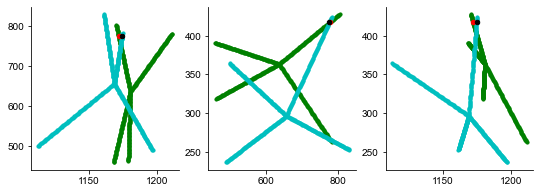

In [13]:
i = 32
c1 = pps[i][0]//360
c2 = pps[i][1]//360

def plot_gap_junc(i, x, y, ax):

    fdraw = ax.scatter
    fdraw(mlipop.dends.coo[(c1*360):((c1+1)*360),x],
                mlipop.dends.coo[(c1*360):((c1+1)*360),y], 10, 'g')
    fdraw(mlipop.dends.coo[(c2*360):((c2+1)*360),x],
                mlipop.dends.coo[(c2*360):((c2+1)*360),y], 10,'c')
    fdraw(mlipop.dends.coo[pps[i][0],x],
                mlipop.dends.coo[pps[i][0],y], 20, 'r')
    fdraw(mlipop.dends.coo[pps[i][1],x],
                mlipop.dends.coo[pps[i][1],y], 20, 'k')


_, axs = plt.subplots(ncols=3, figsize=(9,3))
plot_gap_junc(i, 0, 1, axs[0])
plot_gap_junc(i, 1, 2, axs[1])
plot_gap_junc(i, 0, 2, axs[2])


## Synaptic

In [28]:
# axont, id_axons = mlipop.gen_axon()
mlipop.add_axon()

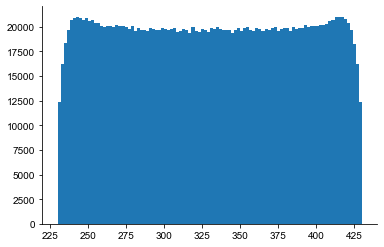

In [29]:
plt.hist(mlipop.axons.coo[:,2],100);

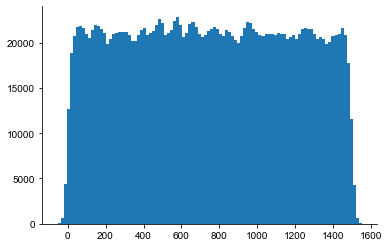

In [30]:
plt.hist(mlipop.axons.coo[:,0],100);

In [31]:
from scipy.spatial import KDTree
import pandas as pd


cdist_syn = 2
fext = 0.2

dend_coo_rescaled = np.zeros(mlipop.dends.coo.shape)
dend_coo_rescaled[:,0] = fext*mlipop.dends.coo[:,0]
dend_coo_rescaled[:,1:] = mlipop.dends.coo[:,1:]

axon_coo_rescaled = np.zeros(mlipop.axons.coo.shape)
axon_coo_rescaled[:,0] = fext*mlipop.axons.coo[:,0]
axon_coo_rescaled[:,1:] = mlipop.axons.coo[:,1:]

dend_tree = KDTree(dend_coo_rescaled)
axon_tree = KDTree(axon_coo_rescaled)

for _ in trange(1):
    z = dend_tree.query_ball_tree(axon_tree, cdist_syn)

for _ in trange(1):
    syn_cons = pd.DataFrame([{'src_idx': k, 'tgt_idx': i} for i, x in enumerate(z) if len(x)!=0 for k in x])

del(dend_tree, axon_tree, z)
syn_cons

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,src_idx,tgt_idx
0,605210,3
1,791715,5
2,791715,6
3,1424657,7
4,1963008,8
...,...,...
9714620,1762925,7100635
9714621,1893452,7100635
9714622,1100719,7100636
9714623,1762925,7100636


In [34]:
syn_cons['src_cell'] = mlipop.axons.idx[syn_cons['src_idx']]
syn_cons['tgt_cell'] = mlipop.dends.idx[syn_cons['tgt_idx']]
syn_cons

,src_idx,tgt_idx,src_cell,tgt_cell
0,605210,3,6052,0
1,791715,5,7917,0
2,791715,6,7917,0
3,1424657,7,14246,0
4,1963008,8,19630,0
...,...,...,...,...
9714620,1762925,7100635,17629,19723
9714621,1893452,7100635,18934,19723
9714622,1100719,7100636,11007,19723
9714623,1762925,7100636,17629,19723


In [35]:
syn_cons = syn_cons[syn_cons.src_cell != syn_cons.tgt_cell]
syn_cons

,src_idx,tgt_idx,src_cell,tgt_cell
0,605210,3,6052,0
1,791715,5,7917,0
2,791715,6,7917,0
3,1424657,7,14246,0
4,1963008,8,19630,0
...,...,...,...,...
9714620,1762925,7100635,17629,19723
9714621,1893452,7100635,18934,19723
9714622,1100719,7100636,11007,19723
9714623,1762925,7100636,17629,19723


In [36]:
z1c = mlipop.som[syn_cons.src_cell]
z2c = mlipop.som[syn_cons.tgt_cell]

z1 = np.zeros((z1c.shape[0], 2))
z2 = np.zeros((z2c.shape[0], 2))

z1 = z1c[:,1:]
z2 = z2c[:,1:]

syn_cons['dist_yz'] = np.linalg.norm(z1 - z2, axis=-1)

z1 = np.zeros((z1c.shape[0], 1))
z2 = np.zeros((z2c.shape[0], 1))

z1 = z1c[:,0]
z2 = z2c[:,0]

syn_cons['dist_x'] = np.abs(z1 - z2)
syn_cons

/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_27986/3257064429.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_cons['dist_yz'] = np.linalg.norm(z1 - z2, axis=-1)
/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_27986/3257064429.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_cons['dist_x'] = np.abs(z1 - z2)


,src_idx,tgt_idx,src_cell,tgt_cell,dist_yz,dist_x
0,605210,3,6052,0,47.179330,20.410576
1,791715,5,7917,0,134.438181,27.259371
2,791715,6,7917,0,134.438181,27.259371
3,1424657,7,14246,0,15.552557,11.168551
4,1963008,8,19630,0,124.344890,1.585603
...,...,...,...,...,...,...
9714620,1762925,7100635,17629,19723,127.691073,23.239578
9714621,1893452,7100635,18934,19723,123.486718,25.994774
9714622,1100719,7100636,11007,19723,165.858621,55.158671
9714623,1762925,7100636,17629,19723,127.691073,23.239578


In [39]:
f1 = lambda xc: 1# 1/(1+np.exp((xc-140)/5))/(1+np.exp((-xc+50)/30))
f2 = lambda xc: 1# 1/(1+np.exp((xc-45)/3))/(1+np.exp((-xc+10)/20))
syn_cons['p_retain'] = f1(syn_cons.dist_yz)*f2(syn_cons.dist_x)

r = np.random.rand(syn_cons.shape[0])
z = (syn_cons.p_retain>r)
syn_cons_final = syn_cons[z]
idx = syn_cons_final.loc[:,['src_cell', 'tgt_cell']].drop_duplicates().index
print(syn_cons_final.shape[0])
syn_cons_final = syn_cons_final.loc[idx,:]
print(syn_cons_final.shape[0])
syn_cons_final

/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_27986/1861814760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_cons['p_retain'] = f1(syn_cons.dist_yz)*f2(syn_cons.dist_x)


9595479
3817062


,src_idx,tgt_idx,src_cell,tgt_cell,dist_yz,dist_x,p_retain
0,605210,3,6052,0,47.179330,20.410576,1
1,791715,5,7917,0,134.438181,27.259371,1
3,1424657,7,14246,0,15.552557,11.168551,1
4,1963008,8,19630,0,124.344890,1.585603,1
5,1855755,9,18557,0,121.465487,8.619341,1
...,...,...,...,...,...,...,...
9714615,270916,7100634,2709,19723,199.834434,26.544803,1
9714617,941455,7100634,9414,19723,238.501072,40.689195,1
9714619,901889,7100635,9018,19723,76.623952,69.194169,1
9714620,1762925,7100635,17629,19723,127.691073,23.239578,1


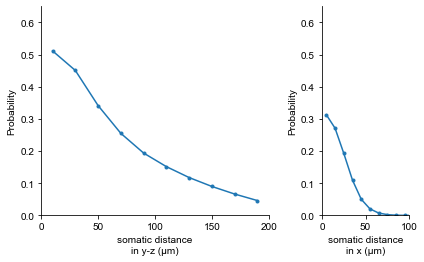

In [40]:
nc, x = np.histogram(syn_cons_final.dist_yz, np.arange(0, 220, 20))
dA = (x[1:]**2-x[:-1]**2)*np.pi

n = nc/(1e-4*1e2*dA)/mlipop.som.shape[0]
# n0, x0 = np.histogram(dist0, np.arange(201))

fig = plt.figure(figsize=(4*1.5,2.5*1.5))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0:2])

xc = (x[:-1]+x[1:])/2
ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-115)/5))*1/(1+np.exp((-xc+4)/10)), '.-', label='corrected')

df_plot_yz['nc_syn'] = nc
df_plot_yz['n_syn'] = n


# ax.plot(xc, n*np.exp(-xc/48), '.-', label='corrected')
# ax.plot(x0[:-1], n0)
ax.set(
    xlim=[0, 200], ylim=[0, 0.65],
    xlabel='somatic distance\nin y-z (μm)',
    ylabel='Probability'
)
# ax.legend()

nc, x = np.histogram(syn_cons_final.dist_x, np.arange(0, 111, 10))
n = nc/(2e2*mlipop.som.shape[0])

ax = fig.add_subplot(gs[0, 2])
xc = (x[:-1]+x[1:])/2
ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-25)/5)), '.-', label='corrected')
ax.set(
    xlim=[0, 100], ylim=[0,0.65],
    xlabel='somatic distance\nin x (μm)',
    ylabel='Probability'
)
# ax.legend()

df_plot_x['nc_syn'] = nc
df_plot_x['n_syn'] = n


plt.tight_layout()
# plt.savefig('ngap_vs_dist.png', dpi=60)

In [376]:
# nc, x = np.histogram(dist_yz, np.arange(0, 220, 20))
# dA = (x[1:]**2-x[:-1]**2)*np.pi

# n = nc/(1e-4*1e2*dA)/mlipop.som.shape[0]
# # n0, x0 = np.histogram(dist0, np.arange(201))

# fig = plt.figure(figsize=(4*1.5,2.5*1.5))
# gs = fig.add_gridspec(1, 3)
# ax = fig.add_subplot(gs[0, 0:2])

# xc = (x[:-1]+x[1:])/2
# ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-140)/6))*1/(1+np.exp((-xc+50)/50)), '.-', label='corrected')

# # ax.plot(xc, n*np.exp(-xc/48), '.-', label='corrected')
# # ax.plot(x0[:-1], n0)
# ax.set(
#     xlim=[0, 200], ylim=[0, 0.65],
#     xlabel='somatic distance\nin y-z (μm)',
#     ylabel='Probability'
# )
# # ax.legend()

# nc, x = np.histogram(dist_x, np.arange(0, 111, 10))
# n = nc/(2e2*mlipop.som.shape[0])

# ax = fig.add_subplot(gs[0, 2])
# xc = (x[:-1]+x[1:])/2
# ax.plot(xc, n, '.-', label='raw')
# ax.plot(xc, n*1/(1+np.exp((xc-50)/4))*1/(1+np.exp((-xc+4)/10)), '.-', label='corrected')
# ax.set(
#     xlim=[0, 100], ylim=[0,0.65],
#     xlabel='somatic distance\nin x (μm)',
#     ylabel='Probability'
# )
# ax.legend()

# plt.tight_layout()
# # plt.savefig('ngap_vs_dist.png', dpi=60)

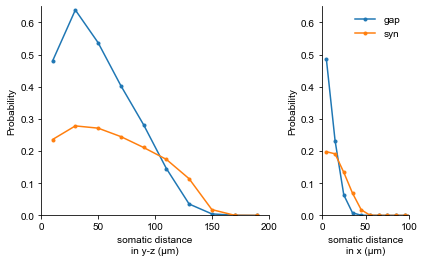

In [453]:
fig = plt.figure(figsize=(4*1.5,2.5*1.5))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0:2])

xc, n1, n2 = df_plot_yz['d'], df_plot_yz['n_gap'], df_plot_yz['n_syn']
ax.plot(xc, n1, '.-', label='gap')
ax.plot(xc, n2, '.-', label='syn')

# ax.plot(xc, n*np.exp(-xc/48), '.-', label='corrected')
# ax.plot(x0[:-1], n0)
ax.set(
    xlim=[0, 200], ylim=[0, 0.65],
    xlabel='somatic distance\nin y-z (μm)',
    ylabel='Probability'
)
# ax.legend()

xc, n1, n2 = df_plot_x['d'], df_plot_x['n_gap'], df_plot_x['n_syn']


ax = fig.add_subplot(gs[0, 2])
ax.plot(xc, n1, '.-', label='gap')
ax.plot(xc, n2, '.-', label='syn')
ax.set(
    xlim=[0, 100], ylim=[0,0.65],
    xlabel='somatic distance\nin x (μm)',
    ylabel='Probability'
)
ax.legend()


plt.tight_layout()
plt.savefig('all_prob_vs_dist.png', dpi=600)

In [446]:
df_plot_yz

,d,nc_gap,n_gap,nc_syn,n_syn
0,10.0,119052,0.480321,58504,0.236037
1,30.0,475079,0.638910,206981,0.278358
2,50.0,665774,0.537220,336301,0.271365
3,70.0,700105,0.403516,425192,0.245066
4,90.0,628862,0.281908,471191,0.211227
5,110.0,397649,0.145849,474978,0.174211
6,130.0,114116,0.035416,367504,0.114055
7,150.0,17235,0.004636,67047,0.018034
8,170.0,1927,0.000457,1447,0.000343
9,190.0,220,0.000047,21,0.000004


In [428]:
ss = syn_cons_final.loc[ind,:]

In [429]:
ss

,src_idx,tgt_idx,src_cell,tgt_cell,dist_yz,dist_x,p_retain
1,1436427,3,14364,0,64.200757,24.565381,0.415109
4,303602,5,3036,0,27.694701,16.837934,0.188381
6,493056,6,4930,0,43.654160,15.254503,0.252857
12,323934,8,3239,0,111.859012,5.801150,0.395760
13,491080,8,4910,0,42.608949,20.741871,0.276805
...,...,...,...,...,...,...,...
9717372,1017443,7100617,10174,19723,131.899082,25.557656,0.536192
9717378,1838185,7100619,18381,19723,77.716271,9.704119,0.355264
9717394,552933,7100627,5529,19723,137.090894,28.070727,0.431261
9717395,1550053,7100629,15500,19723,87.549404,20.863599,0.491691
